In [1]:
# Import libraries
import numpy as np
import time
import os
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import cv2 
import multiprocessing as mp
import imp
import threading
import matplotlib.pyplot as plt



%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#full dataset reading
df=pd.read_csv('/kaggle/input/28thjune-set/text_dataset.tsv',sep='\t')
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named 'df'
# Splitting into training set (80%) and temporary set (20%)
train_temp, test_temp = train_test_split(df, test_size=0.2, stratify=df['6_way_label'] ,random_state=42)

# Splitting the temporary set into test set (50%) and validation set (50%)
test, val = train_test_split(test_temp, test_size=0.5,stratify=test_temp['6_way_label'] , random_state=42)

# Print the sizes of each set
print("Training set size:", len(train_temp))
print("Test set size:", len(test))
print("Validation set size:", len(val))

Training set size: 43793
Test set size: 5474
Validation set size: 5475


/tmp/ipykernel_32/3269052006.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/kaggle/input/28thjune-set/text_dataset.tsv',sep='\t')


In [3]:
# Train data 
multi_traindata = train_temp
# Validation data 
multi_validata = val
# Test data 
multi_testdata = test

In [4]:
# Train data with no missing values
train_data = multi_traindata[multi_traindata['title'].notna()]

# Validation data with no missing values
valid_data = multi_validata[multi_validata['title'].notna()]

# Test data with no missing values
test_data = multi_testdata[multi_testdata['title'].notna()]

In [5]:
train_news, train_labels, train_images = train_data['title'].tolist(), train_data['6_way_label'].tolist(), train_data['id'].tolist()
valid_news, valid_labels, valid_images = valid_data['title'].tolist(), valid_data['6_way_label'].tolist(), valid_data['id'].tolist()
test_news, test_labels, test_images = test_data['title'].tolist(), test_data['6_way_label'].tolist(), test_data['id'].tolist()

In [6]:
def add_suffix(images, suffix='.jpg'):
    return [image + suffix for image in images]

train_images_final = add_suffix(train_images)
valid_images_final = add_suffix(valid_images)
test_images_final = add_suffix(test_images)

In [7]:
import re
def preprocess_text(sentence):
    return re.sub(r'[^a-zA-Z\s]|\s+', ' ', sentence)

In [8]:
# Preprocess the news text
train_news_clean = [preprocess_text(new) for new in train_news]
valid_news_clean = [preprocess_text(new) for new in valid_news]
test_news_clean = [preprocess_text(new) for new in test_news]

In [9]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the English language model in spaCy
nlp = spacy.load('en_core_web_sm')

# Define the set of stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords_lem(text):
    # Tokenize the text
    doc = nlp(text)
    
    # Lemmatize and remove stopwords
    filtered_words = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    
    # Return the filtered words as a joined string
    return ' '.join(filtered_words)

# Stop-words removal and lemmatization
train_stwrd_lem = [remove_stopwords_lem(new) for new in train_news_clean]
valid_stwrd_lem = [remove_stopwords_lem(new) for new in valid_news_clean]
test_stwrd_lem = [remove_stopwords_lem(new) for new in test_news_clean]


In [10]:

#news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem
tokenizer = Tokenizer(num_words = 128022)
#tokenizer.fit_on_texts(news_all)
tokenizer.fit_on_texts(train_stwrd_lem)
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)


In [11]:
# Obtain the vocabulary length

print("Vocabulary length: ", len(tokenizer.word_index))

Vocabulary length:  30776


In [12]:
# Pad/truncate the tokenized news
# Train
train_tokenized_padding = pad_sequences(train_tokenized, maxlen = 15, truncating='post', padding='post')

# Validation
valid_tokenized_padding = pad_sequences(valid_tokenized, maxlen = 15, truncating='post', padding='post')

# Test
test_tokenized_padding = pad_sequences(test_tokenized, maxlen = 15, truncating='post', padding='post')

In [13]:
def load_embedd(filename):
    words = []
    vectors = []
    with open(filename,'r', encoding="utf8") as file:
        for line in file:
           row = line.split(' ')
           vocab = row[0]
           embd = list(map(float, row[1:-1]))
           words.append(vocab)
           vectors.append(embd)
           words, vectors
    return words, vectors




In [14]:
def embed_matrix(word_index, vocab, embeddings, vocab_len, embedding_len):
    embedding_matrix = np.zeros((vocab_len + 1, embedding_len))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector = embeddings[idx]
            vector = np.pad(vector, (0, embedding_len - len(vector)), 'constant')
            embedding_matrix[i] = vector
    return embedding_matrix




In [15]:
# Use GloVe embeddings of dimension 300
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/kaggle/input/glove6b300dtxt/glove.6B.300d.txt")

In [16]:
# Create the embedding matrix
word_index = tokenizer.word_index
embedding_matrix_gv_300 = embed_matrix(word_index=word_index, vocab=vocab_gv_300, embeddings=vectors_gv_300,
vocab_len=110688, embedding_len=300)

In [17]:
# Get names of available images
all_images = os.listdir("/kaggle/input/28thjune-set/image_dataset/")
path = "/kaggle/input/28thjune-set/image_dataset/"


print("length all_images:",len(all_images))

length all_images: 54742


In [18]:
def pad_images(image):
    h, w, c = image.shape
    img_reshaped = np.zeros((3, 560, 560))
    rh = min(h, 560)
    rw = min(w, 560)
    img_reshaped[0, :rh, :rw] = image[:rh, :rw, 0]
    img_reshaped[1, :rh, :rw] = image[:rh, :rw, 1]
    img_reshaped[2, :rh, :rw] = image[:rh, :rw, 2]
    return img_reshaped

In [19]:
# Create model

class CNN_Title_Images(nn.Module):
    
    def __init__(self, image_dimx, nlabels):
        super().__init__()
        
        # Embedding layer for the titles
        self.title_embedding = nn.Embedding(
            num_embeddings=110688,
            embedding_dim=300
        )
        self.title_embedding.weight = nn.Parameter(
            torch.from_numpy(embedding_matrix_gv_300),
            requires_grad=False
        )
        
        # Convolutional layer for the images
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Convolutional layer for the titles
        self.title_cnn = nn.ModuleList([
            nn.Conv2d(1, 50, (k, 300), padding=(k-1,0))
            for k in [2, 3, 4, 5]
        ])
        
        self.fc1 = nn.Linear(200 + 3 * 137 * 137, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, nlabels)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        # Dimension of the image at the output of the second convolutional layer
        self.final_image_dim = int(((image_dimx - 4) / 2 - 4) / 2)

    def forward(self, image, title):
        # Pass the image tensor through the CNN operations
        image = self.image_cnn(image)
        image = image.view(image.shape[0], self.final_image_dim * self.final_image_dim * 3)

        # Pass the title tensor through the different operations
        title = self.title_embedding(title)
        title = title.unsqueeze(1)
        title = [F.relu(conv(title.float())).squeeze(3) for conv in self.title_cnn]
        title = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in title] 
        title = torch.cat(title, 1)
        
        # Join image and title output
        x = torch.cat([image, title], 1)
        
        # Pass result through the linear layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x
    

In [20]:
# Instantiate the model
model_CNN_image_text = CNN_Title_Images(image_dimx = 560 ,nlabels = 6 )

In [21]:
from tqdm import tqdm

# Create counter to be used in the loop
counter = 0
# Error function
criterion = nn.NLLLoss()
# Optimizer
optimizer = torch.optim.AdamW(model_CNN_image_text.parameters(), lr=0.001)
# To store training accuracy
train_accuracy = 0
# To store the number of training batches processed
train_batches_processed = 0

images_tensor = torch.zeros(60, 3, 560, 560)
titles_tensor = torch.zeros(60, 15)
labels_tensor = torch.zeros(60)

# Use tqdm to track progress
for i in tqdm(range(len(train_images_final))):
    
    # First check if image is available
    img = cv2.imread(os.path.join(path, train_images_final[i])) 
        
    if type(img) is not type(None):
        counter += 1 
        
        # Pad image with zeros or truncate it to obtain 560 x 560 shape
        img_padded = pad_images(img)
        
        # Store image, corresponding title, and label 
        images_tensor[counter-1, :,:,:] = torch.from_numpy(img_padded)
        titles_tensor[counter-1, :] = torch.from_numpy(train_tokenized_padding[i]).int()
        labels_tensor[counter - 1] = train_labels[i]
           
        
        if counter % 60 == 0: 
           train_batches_processed += 1

           # Reset gradients
           optimizer.zero_grad() 

           # Pass image and text through the different layers
           out = model_CNN_image_text.forward(images_tensor, titles_tensor.long())            
            # Compute loss
           loss = criterion(out, labels_tensor.long())

            
           # Backpropagation
           loss.backward()
        
           # Optimize parameters
           optimizer.step()
            
           # Obtain number of correct predictions and store accuracy
           top_p, top_class = out.topk(1, dim=1) 
           equals = (top_class == labels_tensor.view(images_tensor.shape[0], 1))
           train_accuracy += torch.mean(equals.type(torch.FloatTensor))

           # Reset image, title, and label tensors
           images_tensor = torch.zeros(60, 3, 560, 560)
           titles_tensor = torch.zeros(60, 15)
           labels_tensor = torch.zeros(60)
            
           counter = 0 
                
           # Print average accuracy every 100 training batches
           if train_batches_processed % 100 == 0:
                avg_accuracy = train_accuracy / train_batches_processed
                tqdm.write("Average Training Accuracy: {:.4f}".format(avg_accuracy))


 14%|█▎        | 6014/43793 [05:25<45:12, 13.93it/s]  

Average Training Accuracy: 0.4305


 27%|██▋       | 12006/43793 [10:52<1:05:49,  8.05it/s]

Average Training Accuracy: 0.5076


 41%|████      | 18008/43793 [16:25<41:30, 10.35it/s]  

Average Training Accuracy: 0.5529


 55%|█████▍    | 24012/43793 [22:36<29:12, 11.29it/s]  

Average Training Accuracy: 0.5800


 69%|██████▊   | 30009/43793 [28:53<19:52, 11.56it/s]

Average Training Accuracy: 0.6004


 82%|████████▏ | 36011/43793 [35:26<11:48, 10.99it/s]  

Average Training Accuracy: 0.6142


 96%|█████████▌| 42016/43793 [41:20<02:34, 11.48it/s]

Average Training Accuracy: 0.6240


100%|██████████| 43793/43793 [43:29<00:00, 16.78it/s]


In [22]:
counter = 0
batch_size = 60
images_tensor = torch.zeros(batch_size, 3, 560, 560)
titles_tensor = torch.zeros(batch_size, 15).int()
labels_tensor = torch.zeros(batch_size).int()

predictions = []
labels_test = []

# Evaluation pass
with torch.no_grad():
    model_CNN_image_text.eval()  # Set the model to evaluation mode
    for i in range(len(test_images_final)):
        # First check if image is available
        img = cv2.imread(path + test_images_final[i])
        if type(img) is not type(None):
            # Add 1 to counter
            counter += 1
            # Pad it with zeros to obtain 560 x 560 shape
            img_padded = pad_images(img)
            # Store image and corresponding title and label 
            images_tensor[counter - 1, :, :, :] = torch.from_numpy(img_padded)
            titles_tensor[counter - 1, :] = torch.from_numpy(test_tokenized_padding[i])
            labels_tensor[counter - 1] = test_labels[i] 
            if counter % batch_size == 0:
                # Pass image and text through the different layers
                out = model_CNN_image_text(images_tensor, titles_tensor)
                # Obtain predictions
                top_p, top_class = out.topk(1, dim=1)
                predictions.extend(top_class.numpy().flatten().tolist())
                labels_test.extend(labels_tensor.numpy().tolist())
                # Reset tensors
                images_tensor = torch.zeros(batch_size, 3, 560, 560)
                titles_tensor = torch.zeros(batch_size, 15).int()
                labels_tensor = torch.zeros(batch_size).int()
                counter = 0
    # Process the remaining data
    if counter > 0:
        out = model_CNN_image_text(images_tensor[:counter, ...], titles_tensor[:counter, ...])
        top_p, top_class = out.topk(1, dim=1)
        predictions.extend(top_class.numpy().flatten().tolist())
        labels_test.extend(labels_tensor[:counter].numpy().tolist())

predictions = np.array(predictions)
labels_test = np.array(labels_test)

In [23]:
print(classification_report(labels_test, predictions, labels=[0, 1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       897
           1       0.75      0.67      0.71       897
           2       0.60      0.59      0.59       892
           3       0.56      0.55      0.56       925
           4       0.93      1.00      0.96       934
           5       0.78      0.78      0.78       929

    accuracy                           0.70      5474
   macro avg       0.69      0.69      0.69      5474
weighted avg       0.69      0.70      0.69      5474



RANDOM SAMPLES




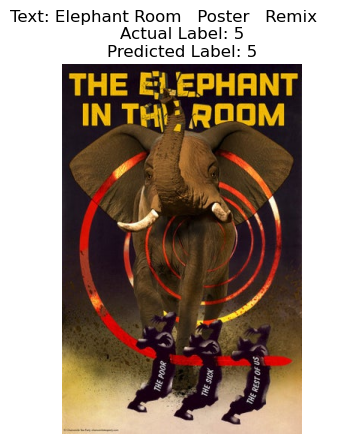

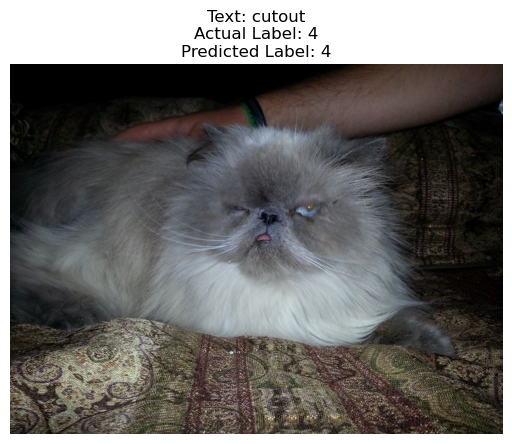

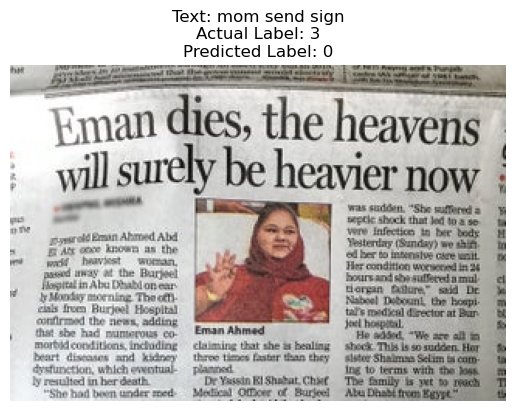

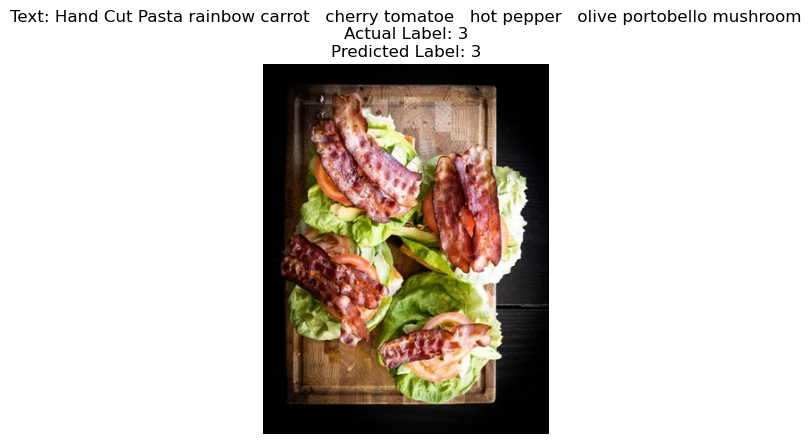

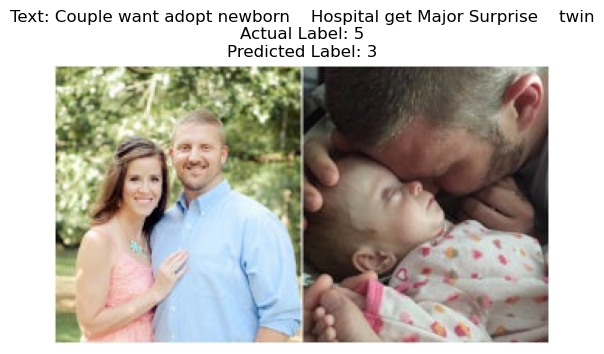

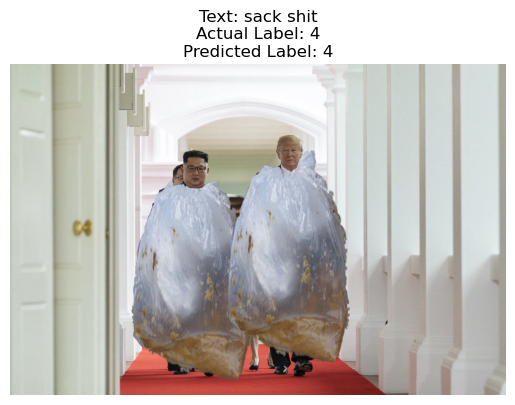

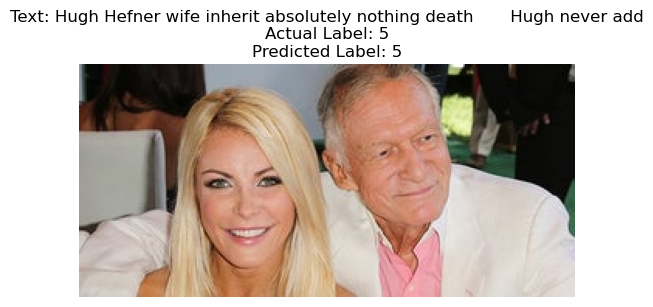

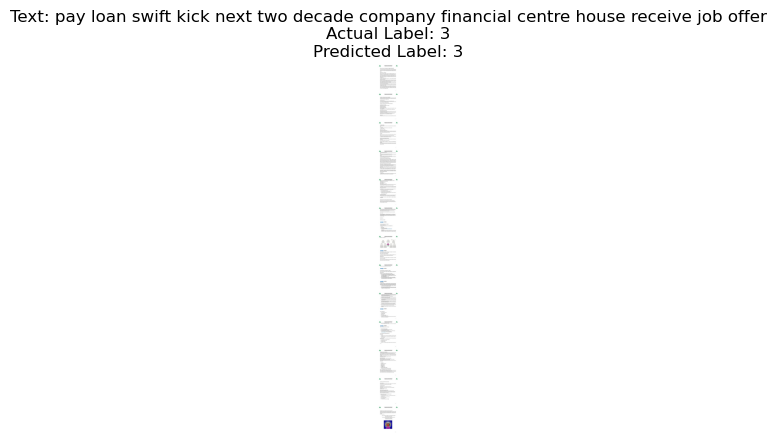

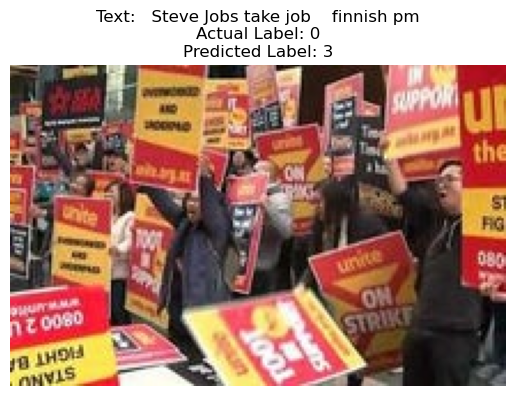

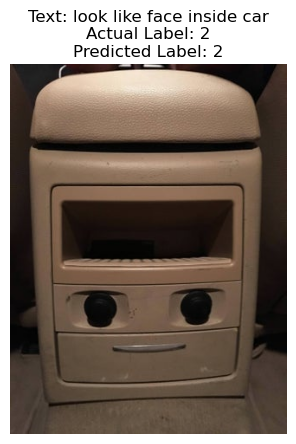

In [24]:
import random

# Function to display images and corresponding text
def display_samples(images, texts, labels, predictions, num_samples):
    # Select random samples
    sample_indices = random.sample(range(len(images)), num_samples)

    for idx in sample_indices:
        img = mpimg.imread('/kaggle/input/28thjune-set/image_dataset/'+images[idx])
        plt.imshow(img)
        plt.title("Text: {}\nActual Label: {}\nPredicted Label: {}".format(texts[idx], labels[idx], predictions[idx]))
        plt.axis('off')
        plt.show()

# Function to display mispredicted samples
def display_mispredicted(images, texts, labels, predictions, num_samples):
    mispredicted_indices = [idx for idx in range(len(images)) if labels[idx] != predictions[idx]]
    mispredicted_samples = random.sample(mispredicted_indices, num_samples)

    for idx in mispredicted_samples:
        img = mpimg.imread('/kaggle/input/28thjune-set/image_dataset/'+images[idx])
        plt.imshow(img)
        plt.title("Text: {}\nActual Label: {}\nPredicted Label: {}".format(texts[idx], labels[idx], predictions[idx]))
        plt.axis('off')
        plt.show()

print("RANDOM SAMPLES")
print('\n')
# Display 10 random samples
display_samples(test_images_final, test_stwrd_lem, test_labels, predictions, num_samples=10)




MISPREDICTED SAMPLES




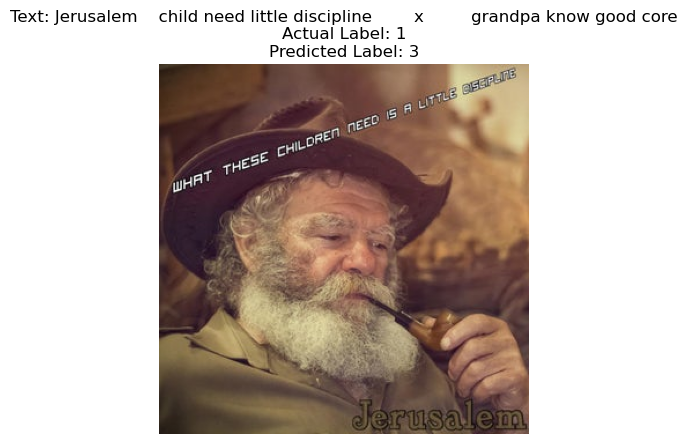

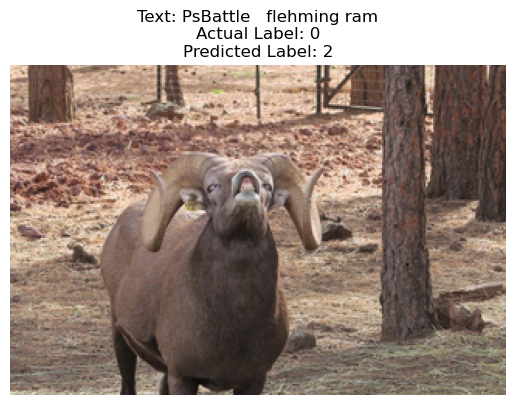

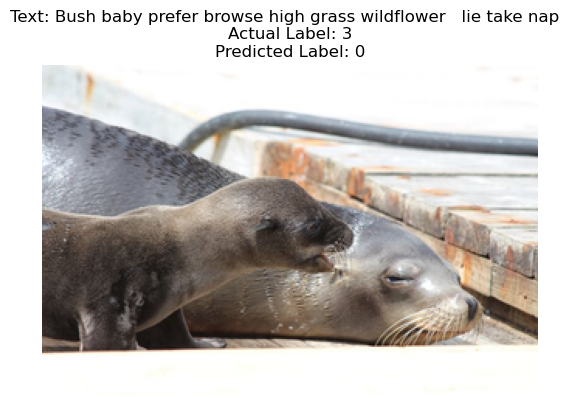

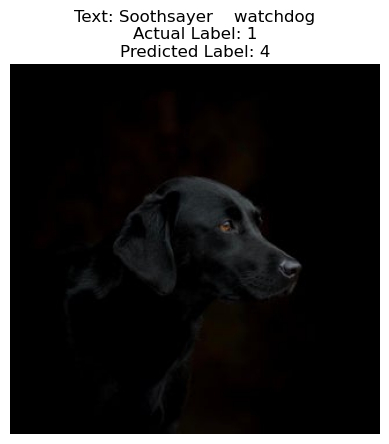

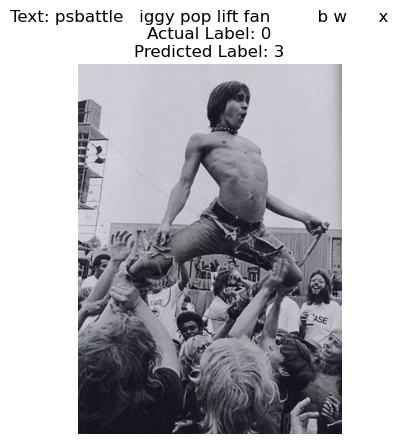

In [25]:

print("MISPREDICTED SAMPLES")
print('\n')

# Display 5 random mispredicted samples
display_mispredicted(test_images_final, test_stwrd_lem, test_labels, predictions, num_samples=5)